# Investigate Atlas predictions

Given the Atlas predictions for the ParaRel queries we can do a manual analysis of the results.

## Load the predictions

Move to project home folder to make module imports etc. work.

In [1]:
%cd ..

/Users/lovhag/Library/CloudStorage/OneDrive-Chalmers/Documents/Projects/pararel


In [2]:
from pararel.consistency.utils import read_jsonl_file
import re
import pandas as pd
import pickle
import numpy as np
import os

In [190]:
atlas_preds_file = "/Users/lovhag/Library/CloudStorage/OneDrive-Chalmers/Documents/Projects/pararel/data/atlas_results/new/pararel-eval-with-confidences/P27-base-2017-1233489/P27-step-0.jsonl"
pararel_options_file = "/Users/lovhag/Library/CloudStorage/OneDrive-Chalmers/Documents/Projects/pararel/data/all_n1_atlas/P27_options.txt"

data = read_jsonl_file(atlas_preds_file)

with open(pararel_options_file) as f:
    options = [line.strip() for line in f.readlines()]

In [265]:
pd_data = pd.DataFrame(data)
pd_data["choice_confidence"] = pd_data["choice_confidence"].astype("float")
pd_data.head()

,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern
0,"Rubens Barrichello, who is a citizen of<extra_...",[Brazil],"Brazil Brazil, is Brazilian Brazil a member of...",Brazil,0.986,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who is a citizen of [Y]."
1,"Rubens Barrichello, who has a citizenship of<e...",[Brazil],"Brazil Brazil, is Brazilian Brazil a driver of...",Brazil,0.923,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who has a citizenship of [Y]."
2,"Yves Mirande, a citizen of<extra_id_0>.",[France],"France France, died in 1957 France Yves",France,0.976,"[{'id': '10883439', 'title': 'Yves Mirande', '...",{},Yves Mirande,"[X], a citizen of [Y]."
3,"Yves Mirande, who holds a citizenship of<extra...",[France],"France France, is French France Yves of France...",France,0.739,"[{'id': '6775490', 'title': 'Thiago Pereira (f...",{},Yves Mirande,"[X], who holds a citizenship of [Y]."
4,August Gailit is a citizen of<extra_id_0>.,[Estonia],Estonia Estonia and Latvia Estonia he was born...,Estonia,0.902,"[{'id': '21850689', 'title': 'August Gailit', ...",{},August Gailit,[X] is a citizen of [Y].


## Validate Atlas answer decoding procedure

Rudimentary check: If any of the answer options has been generated by the unconstrained decoding, that should be the model answer. 

In [191]:
# given greedy and decoded predictions
error_ixs = []
for ix, entry in enumerate(data):
    option_in_generation = False
    option_also_in_constrained_generation = False
    # do not investigate non-erroneous cases further
    if entry["generation_by_choice"] == entry["answers"][0]:
        continue
    # do not investigate cases for which the free generation doesn't contain the right answer
    if not entry["answers"][0] in re.split(' |\.|!|\?', entry["generation"]):
        continue
    for option in options:
        if option in re.split(' |\.|!|\?', entry["generation"]):
            option_in_generation = True
            if option in [entry["generation_by_choice"]]:
                option_also_in_constrained_generation = True
    if option_in_generation and not option_also_in_constrained_generation:
        error_ixs += [ix]
print(f"Found {len(error_ixs)} mismatching and erroneous generations out of {len(data)} predictions")

Found 92 mismatching and erroneous generations out of 8622 predictions


Check the error cases

In [193]:
for error_ix in error_ixs:
    print(f"query: {data[error_ix]['query']}")
    print(f"answers: {data[error_ix]['answers']}")
    print(f"generation: {data[error_ix]['generation']}")
    print(f"generation_by_choice: {data[error_ix]['generation_by_choice']}")
    print("--------------------------------------------")

query: Prafulla Chandra Ghosh has a citizenship of<extra_id_0>.
answers: ['India']
generation: British India British India British India a British Indian, a British India
generation_by_choice: Bangladesh
--------------------------------------------
query: Prince Leka of Albania, who is a citizen of<extra_id_0>.
answers: ['Albania']
generation: the United Kingdom Albania the United Kingdom is the only child of Albania Albania Albania.
generation_by_choice: Spain
--------------------------------------------
query: Charles II of Spain, who is a citizen of<extra_id_0>.
answers: ['Spain']
generation: the United Kingdom the United Kingdom Spain of Spain of Spain the United Kingdom the United Kingdom
generation_by_choice: Austria
--------------------------------------------
query: Peter Canisius is<extra_id_0> citizen.
answers: ['Netherlands']
generation: a Dutch and a Dutch of the Netherlands.
generation_by_choice: Austria
--------------------------------------------
query: Peter Canisius ho

## Switch analysis to predictions based on most frequent candidate in retrieved passages
A baseline always guessing on the answer option most frequent in the retrieved passage

In [206]:
def get_most_frequent_candidate(candidates, passages):
    max_term_count = 0
    most_frequent_candidate = None
    for term in candidates:
        term_count = 0
        for passage in passages:
            term_count += passage['title'].count(term) + passage['text'].count(term)
        if term_count > max_term_count:
            max_term_count = term_count
            most_frequent_candidate = term
    return most_frequent_candidate

pd_data["passage_freq_pred"] = pd_data.apply(lambda row: get_most_frequent_candidate(options, row.passages), axis=1)
pd_data

,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern,passage_freq_pred
0,"Rubens Barrichello, who is a citizen of<extra_...",[Brazil],"Brazil Brazil, is Brazilian Brazil a member of...",Brazil,0.986,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who is a citizen of [Y].",Brazil
1,"Rubens Barrichello, who has a citizenship of<e...",[Brazil],"Brazil Brazil, is Brazilian Brazil a driver of...",Brazil,0.923,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who has a citizenship of [Y].",Brazil
2,"Yves Mirande, a citizen of<extra_id_0>.",[France],"France France, died in 1957 France Yves",France,0.976,"[{'id': '10883439', 'title': 'Yves Mirande', '...",{},Yves Mirande,"[X], a citizen of [Y].",France
3,"Yves Mirande, who holds a citizenship of<extra...",[France],"France France, is French France Yves of France...",France,0.739,"[{'id': '6775490', 'title': 'Thiago Pereira (f...",{},Yves Mirande,"[X], who holds a citizenship of [Y].",France
4,August Gailit is a citizen of<extra_id_0>.,[Estonia],Estonia Estonia and Latvia Estonia he was born...,Estonia,0.902,"[{'id': '21850689', 'title': 'August Gailit', ...",{},August Gailit,[X] is a citizen of [Y].,Estonia
...,...,...,...,...,...,...,...,...,...,...
8617,"Gianni Ferrio, who has a citizenship of<extra_...",[Italy],"Italy Italy, is Italian Italy -born in Italy -...",Italy,0.740,"[{'id': 'infobox-475667', 'title': 'Gianni Fer...",{},Gianni Ferrio,"[X], who has a citizenship of [Y].",Italy
8618,"Sun Beibei, a citizen of<extra_id_0>.",[Singapore],Shandong Shandong Shandong Shandong,Taiwan,0.557,"[{'id': 'infobox-1956267', 'title': 'Sun Beibe...",{},Sun Beibei,"[X], a citizen of [Y].",None
8619,"Sun Beibei, who holds a citizenship of<extra_i...",[Singapore],"Singapore Singapore, is also Chinese Singapore...",Singapore,0.650,"[{'id': 'infobox-1860120', 'title': 'Sun Le', ...",{},Sun Beibei,"[X], who holds a citizenship of [Y].",Singapore
8620,Edward Wollstonecraft is a citizen of<extra_id...,[Australia],New South Wales New South Wales.,Australia,0.891,"[{'id': 'infobox-1461400', 'title': 'Edward Wo...",{},Edward Wollstonecraft,[X] is a citizen of [Y].,England


Check number of occassions for which most frequent prediction and made prediction match

In [212]:
sum(pd_data.passage_freq_pred==pd_data.generation_by_choice)/len(pd_data)

0.640222686151705

If wish to do analysis as if these were model predictions

In [ ]:
pd_data["generation_by_choice" = pd_data["passage_freq_pred"]

Get entropy of candidate frequency distribution for retrieved passages

In [264]:
from scipy.stats import entropy

def get_freq_distrib_entropy(candidates, passages):
    term_counts = []
    for term in candidates:
        term_count = 0
        for passage in passages:
            term_count += passage['title'].count(term) + passage['text'].count(term)
        term_counts.append(term_count)
    return entropy(term_counts)

pd_data["passage_freq_entropy"] = pd_data.apply(lambda row: get_freq_distrib_entropy(options, row.passages), axis=1)
pd_data

/Users/lovhag/envs/pararel_plot_env/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern,passage_freq_pred,passage_freq_entropy,incons_label,pred_passage_rank
0,"Rubens Barrichello, who is a citizen of<extra_...",[Brazil],"Brazil Brazil, is Brazilian Brazil a member of...",Brazil,0.986,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who is a citizen of [Y].",Brazil,1.167357,False,1
1,"Rubens Barrichello, who has a citizenship of<e...",[Brazil],"Brazil Brazil, is Brazilian Brazil a driver of...",Brazil,0.923,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who has a citizenship of [Y].",Brazil,0.920833,False,1
2,"Yves Mirande, a citizen of<extra_id_0>.",[France],"France France, died in 1957 France Yves",France,0.976,"[{'id': '10883439', 'title': 'Yves Mirande', '...",{},Yves Mirande,"[X], a citizen of [Y].",France,1.722958,False,1
3,"Yves Mirande, who holds a citizenship of<extra...",[France],"France France, is French France Yves of France...",France,0.739,"[{'id': '6775490', 'title': 'Thiago Pereira (f...",{},Yves Mirande,"[X], who holds a citizenship of [Y].",France,1.704070,False,1
4,August Gailit is a citizen of<extra_id_0>.,[Estonia],Estonia Estonia and Latvia Estonia he was born...,Estonia,0.902,"[{'id': '21850689', 'title': 'August Gailit', ...",{},August Gailit,[X] is a citizen of [Y].,Estonia,2.300936,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,"Gianni Ferrio, who has a citizenship of<extra_...",[Italy],"Italy Italy, is Italian Italy -born in Italy -...",Italy,0.740,"[{'id': 'infobox-475667', 'title': 'Gianni Fer...",{},Gianni Ferrio,"[X], who has a citizenship of [Y].",Italy,1.387198,False,1
8618,"Sun Beibei, a citizen of<extra_id_0>.",[Singapore],Shandong Shandong Shandong Shandong,Taiwan,0.557,"[{'id': 'infobox-1956267', 'title': 'Sun Beibe...",{},Sun Beibei,"[X], a citizen of [Y].",None,NaN,True,64
8619,"Sun Beibei, who holds a citizenship of<extra_i...",[Singapore],"Singapore Singapore, is also Chinese Singapore...",Singapore,0.650,"[{'id': 'infobox-1860120', 'title': 'Sun Le', ...",{},Sun Beibei,"[X], who holds a citizenship of [Y].",Singapore,0.450561,True,1
8620,Edward Wollstonecraft is a citizen of<extra_id...,[Australia],New South Wales New South Wales.,Australia,0.891,"[{'id': 'infobox-1461400', 'title': 'Edward Wo...",{},Edward Wollstonecraft,[X] is a citizen of [Y].,England,2.022809,False,5


## Check inconsistent cases

### Consistency analysis

In [4]:
data[0]

{'query': 'Rubens Barrichello, who is a citizen of<extra_id_0>.',
 'answers': ['Brazil'],
 'generation': 'Brazil Brazil, is Brazilian Brazil a member of the Brazilian team ',
 'generation_by_choice': 'Brazil',
 'choice_confidence': '0.986',
 'passages': [{'id': 'infobox-1921947',
   'title': 'Rubens Barrichello',
   'text': 'infobox name: Rubens Barrichello ; image: Rubens Barrichello 2010 Malaysia.jpg ; caption: Barrichello at the 2010 Malaysian Grand Prix ; nationality: 🇧🇷 Brazilian ; birth_name: Rubens Gonçalves Barrichello ; birth_date: May 23, 1972 ; birth_place: São Paulo, Brazil ; current series: Stock Car Brasil ; first year: 2012 ; current team: Full Time Sports ; car number: 111 ; engine: Chevrolet ; starts: 99 ; championships: 1 (2014) ; wins: 7 ; poles: 7 ; best finish: 1st ; year: 2014 ; last finish: 5th (2017) ; child: yes ; years: 1993–2011 ; team(s): Jordan, Stewart, Ferrari, Honda, Brawn, Williams ; races: 326 (322 starts) ; championships: 0 ; wins: 11 ; podiums: 68 ; 

In [266]:
unique_sub_labels = pd_data.sub_label.unique()
incons_labels = []
cons_labels = []

for label in unique_sub_labels:
    if len(pd_data[pd_data.sub_label==label].generation_by_choice.unique()) > 1:
        incons_labels.append(label)
    else:
        cons_labels.append(label)

print(f"Predictions are inconsistent for {len(incons_labels)} subject labels out of a total of {len(unique_sub_labels)} labels.")

Predictions are inconsistent for 215 subject labels out of a total of 958 labels.


In [267]:
pd_data["incons_label"] = pd_data.sub_label.isin(incons_labels)

In [268]:
pd_data[pd_data.sub_label==incons_labels[0]]

,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern,incons_label
6,Princess Elisabeth of Denmark is<extra_id_0> c...,[Denmark],a Danish a Danish a Danish is a is a a Danish ...,Denmark,0.501,"[{'id': '25132407', 'title': 'Orders, decorati...",{},Princess Elisabeth of Denmark,[X] is [Y] citizen.,True
7,Princess Elisabeth of Denmark holds a citizens...,[Denmark],the United Kingdom the United States the Unite...,Romania,0.208,"[{'id': 'infobox-456915', 'title': 'Princess E...",{},Princess Elisabeth of Denmark,[X] holds a citizenship of [Y].,True
8,"as a citizen of<extra_id_0>, Princess Elisabet...",[Denmark],Denmark Denmark.,Denmark,0.841,"[{'id': '4639415', 'title': 'Princess Elisabet...",{},Princess Elisabeth of Denmark,"as a citizen of [Y], [X]",True
2162,Princess Elisabeth of Denmark is a citizen of<...,[Denmark],Denmark Denmark and Denmark proper Denmark Cou...,Denmark,0.960,"[{'id': '11902214', 'title': 'Count Jefferson ...",{},Princess Elisabeth of Denmark,[X] is a citizen of [Y].,True
2163,Princess Elisabeth of Denmark has a citizenshi...,[Denmark],the United Kingdom the United Kingdom Denmark ...,Romania,0.374,"[{'id': '1997777', 'title': 'List of godchildr...",{},Princess Elisabeth of Denmark,[X] has a citizenship of [Y].,True
4318,"Princess Elisabeth of Denmark, a citizen of<ex...",[Denmark],the Danish royal family Denmark the Danish roy...,Germany,0.381,"[{'id': 'infobox-879550', 'title': 'Princess E...",{},Princess Elisabeth of Denmark,"[X], a citizen of [Y].",True
4319,"Princess Elisabeth of Denmark, who holds a cit...",[Denmark],"Denmark Denmark, is married Denmark af Rosenbo...",Denmark,0.755,"[{'id': '4364470', 'title': 'Morganatic marria...",{},Princess Elisabeth of Denmark,"[X], who holds a citizenship of [Y].",True
6474,"Princess Elisabeth of Denmark, who is a citize...",[Denmark],"Denmark Denmark, is married Denmark of Denmark...",Denmark,0.885,"[{'id': '11902214', 'title': 'Count Jefferson ...",{},Princess Elisabeth of Denmark,"[X], who is a citizen of [Y].",True
6475,"Princess Elisabeth of Denmark, who has a citiz...",[Denmark],the United Kingdom the United Kingdom the Unit...,Romania,0.408,"[{'id': '11902214', 'title': 'Count Jefferson ...",{},Princess Elisabeth of Denmark,"[X], who has a citizenship of [Y].",True


### Do the different passages retrieved explain why the model switched prediction?

Look at word counts of prediction.

In [70]:
def get_passage_dict(passages):
    passage_dict = {}
    for passage in passages:
        passage_dict[passage["id"]] = passage
    return passage_dict

def get_diff_passages(passages, other_passages_ids):
    other_passages = []
    for passage in passages:
        if passage["id"] not in other_passages_ids:
            other_passages.append(("   ").join([passage["title"],passage["text"]]))
    return other_passages

def get_terms(text):
    return text.replace("<extra_id_0>","").replace(".","").replace(",","").split()

def get_terms_counts(relevant_terms, passages):
    term_counts = {}
    for term in relevant_terms:
        term_counts[term] = (" ").join(passages).count(term)
    return term_counts

def get_term_count(relevant_term, passages):
    return (" ").join(passages).count(relevant_term)

id_1 = 7
id_2 = 6475

print(pd_data.iloc[[id_1,id_2]].filter(["query","generation_by_choice"]))
passages_1 = pd_data.loc[id_1].passages
passages_2 = pd_data.loc[id_2].passages

psg_ids_1 = {passage["id"] for passage in passages_1}
psg_ids_2 = {passage["id"] for passage in passages_2}
diff_passages_1 = get_diff_passages(passages_1, psg_ids_2)
diff_passages_2 = get_diff_passages(passages_2, psg_ids_1)

# get the terms that matter per paraphrase and prediction instance
relevant_terms_1 = get_terms(pd_data.loc[id_1].query)
relevant_terms_1 += [pd_data.loc[id_1].generation_by_choice]
relevant_terms_1 = set(relevant_terms_1)

relevant_terms_2 = get_terms(pd_data.loc[id_2].query)
relevant_terms_2 += [pd_data.loc[id_2].generation_by_choice]
relevant_terms_2 = set(relevant_terms_2)

term_counts_1 = get_term_counts(relevant_terms_1-relevant_terms_2, diff_passages_1)
term_counts_1_other = get_term_counts(relevant_terms_2-relevant_terms_1, diff_passages_1)
print()
print("Term counts for first instance:")
print("For terms unique to first instance:")
print(term_counts_1)
print("For terms unique to second instance:")
print(term_counts_1_other)

term_counts_2 = get_term_counts(relevant_terms_2-relevant_terms_1, diff_passages_2)
term_counts_2_other = get_term_counts(relevant_terms_1-relevant_terms_2, diff_passages_2)
print()
print("Term counts for second instance:")
print("For terms unique to second instance:")
print(term_counts_2)
print("For terms unique to first instance:")
print(term_counts_2_other)

                                                  query generation_by_choice
7     Princess Elisabeth of Denmark holds a citizens...              Romania
6475  Princess Elisabeth of Denmark, who has a citiz...              Romania

Term counts for first instance:
For terms unique to first instance:
{'holds': 2}
For terms unique to second instance:
{'has': 1, 'who': 1}

Term counts for second instance:
For terms unique to second instance:
{'has': 2, 'who': 7}
For terms unique to first instance:
{'holds': 0}


Seems as though there are cases for which the prediction changes due to the occurrence of one or more of other answer candidates, e.g. Romania instead of Denmark.

Compare occurrence counts of gold label vs. the made prediction. Hypothesis: the reader latches onto even low-frequency answer alternatives, and this causes inconsistency at times.

Bool check: for inconsistent predictions, was the frequency of the prediction made higher? (also check for consistent)

In [68]:
entry

{'consistent': True, 'freq_diff_psgs_1': 0, 'freq_diff_psgs_2': 0}

In [89]:
len(pd_data)

8622

In [93]:
unique_sub_labels = pd_data.sub_label.unique()
consistency_data = pd.DataFrame()

for subj in unique_sub_labels:
    subj_data = pd_data[pd_data.sub_label==subj]
    entry_basics = subj_data.iloc[0].filter(["query","answers","sub_label"]).to_dict()
    ix_to_skip = []
    for ix_1, val_1 in subj_data.iterrows():
        ix_to_skip += [ix_1]
        for ix_2, val_2 in subj_data.drop(index=ix_to_skip).iterrows():
            psg_ids_1 = {passage["id"] for passage in val_1.passages}
            psg_ids_2 = {passage["id"] for passage in val_2.passages}
            diff_passages_1 = get_diff_passages(val_1.passages, psg_ids_2)
            diff_passages_2 = get_diff_passages(val_2.passages, psg_ids_1)

            # get how many more times the chosen prediction occurs the retrieved passages for the first case vs the other
            entry = {"consistent": val_1["generation_by_choice"]==val_2["generation_by_choice"], 
                     "pred_freq_diff": (get_term_count(val_1["generation_by_choice"], diff_passages_1)-get_term_count(val_1["generation_by_choice"], diff_passages_2))} 
            consistency_data = pd.concat((consistency_data, pd.DataFrame(entry, index=[1])), ignore_index=True)
            entry = {"consistent": val_1["generation_by_choice"]==val_2["generation_by_choice"],  
                     "pred_freq_diff": (get_term_count(val_2["generation_by_choice"], diff_passages_2)-get_term_count(val_2["generation_by_choice"], diff_passages_1))} 
            consistency_data = pd.concat((consistency_data, pd.DataFrame(entry, index=[1])), ignore_index=True)

In [94]:
consistency_data

,consistent,pred_freq_diff
0,True,5
1,True,-5
2,True,10
3,True,-10
4,True,9
...,...,...
68971,True,0
68972,True,-5
68973,True,5
68974,True,-5


In [95]:
consistency_data.groupby("consistent").mean()

,pred_freq_diff
consistent,
False,1.096341
True,0.000000


For inconsistent predictions, the prediction that was switched to occurs more frequently in the passages that were retrieved unique to that instance.

### Does the prediction always have some support in the retrieved passages?

In [99]:
pd_data.iloc[0].passages[0]

{'id': 'infobox-1921947',
 'title': 'Rubens Barrichello',
 'text': 'infobox name: Rubens Barrichello ; image: Rubens Barrichello 2010 Malaysia.jpg ; caption: Barrichello at the 2010 Malaysian Grand Prix ; nationality: 🇧🇷 Brazilian ; birth_name: Rubens Gonçalves Barrichello ; birth_date: May 23, 1972 ; birth_place: São Paulo, Brazil ; current series: Stock Car Brasil ; first year: 2012 ; current team: Full Time Sports ; car number: 111 ; engine: Chevrolet ; starts: 99 ; championships: 1 (2014) ; wins: 7 ; poles: 7 ; best finish: 1st ; year: 2014 ; last finish: 5th (2017) ; child: yes ; years: 1993–2011 ; team(s): Jordan, Stewart, Ferrari, Honda, Brawn, Williams ; races: 326 (322 starts) ; championships: 0 ; wins: 11 ; podiums: 68 ; points: 658 ; poles: 14 ; fastest laps: 17 ; first race: 1993 South African Grand Prix ; first win: 2000 German Grand Prix ; last win: 2009 Italian Grand Prix ; last race: 2011 Brazilian Grand Prix ; child: yes ; total_irl_races: 15 ; years_in_irl: 1 ; best_i

In [200]:
def get_term_count_in_passages(term, passages):
    if term is None:
        return None
    term_count = 0
    for passage in passages:
        term_count += passage['title'].count(term) + passage['text'].count(term)
    return term_count

pd_data["pred_psg_count"] = pd_data.apply(lambda row: get_term_count_in_passages(row.generation_by_choice, row.passages), axis=1)
pd_data["sub_label_psg_count"] = pd_data.apply(lambda row: get_term_count_in_passages(row.sub_label, row.passages), axis=1)

In [201]:
pd_data

,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern,incons_label,pred_psg_count,sub_label_psg_count
0,"Rubens Barrichello, who is a citizen of<extra_...",[Brazil],"Brazil Brazil, is Brazilian Brazil a member of...",Brazil,0.986,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who is a citizen of [Y].",False,22.0,24
1,"Rubens Barrichello, who has a citizenship of<e...",[Brazil],"Brazil Brazil, is Brazilian Brazil a driver of...",Brazil,0.923,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who has a citizenship of [Y].",False,17.0,23
2,"Yves Mirande, a citizen of<extra_id_0>.",[France],"France France, died in 1957 France Yves",France,0.976,"[{'id': '10883439', 'title': 'Yves Mirande', '...",{},Yves Mirande,"[X], a citizen of [Y].",True,7.0,11
3,"Yves Mirande, who holds a citizenship of<extra...",[France],"France France, is French France Yves of France...",France,0.739,"[{'id': '6775490', 'title': 'Thiago Pereira (f...",{},Yves Mirande,"[X], who holds a citizenship of [Y].",True,8.0,0
4,August Gailit is a citizen of<extra_id_0>.,[Estonia],Estonia Estonia and Latvia Estonia he was born...,Estonia,0.902,"[{'id': '21850689', 'title': 'August Gailit', ...",{},August Gailit,[X] is a citizen of [Y].,True,6.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
8617,"Gianni Ferrio, who has a citizenship of<extra_...",[Italy],"Italy Italy, is Italian Italy -born in Italy -...",Italy,0.740,"[{'id': 'infobox-475667', 'title': 'Gianni Fer...",{},Gianni Ferrio,"[X], who has a citizenship of [Y].",False,25.0,3
8618,"Sun Beibei, a citizen of<extra_id_0>.",[Singapore],Shandong Shandong Shandong Shandong,None,0.557,"[{'id': 'infobox-1956267', 'title': 'Sun Beibe...",{},Sun Beibei,"[X], a citizen of [Y].",True,NaN,3
8619,"Sun Beibei, who holds a citizenship of<extra_i...",[Singapore],"Singapore Singapore, is also Chinese Singapore...",Singapore,0.650,"[{'id': 'infobox-1860120', 'title': 'Sun Le', ...",{},Sun Beibei,"[X], who holds a citizenship of [Y].",True,5.0,6
8620,Edward Wollstonecraft is a citizen of<extra_id...,[Australia],New South Wales New South Wales.,England,0.891,"[{'id': 'infobox-1461400', 'title': 'Edward Wo...",{},Edward Wollstonecraft,[X] is a citizen of [Y].,True,2.0,5


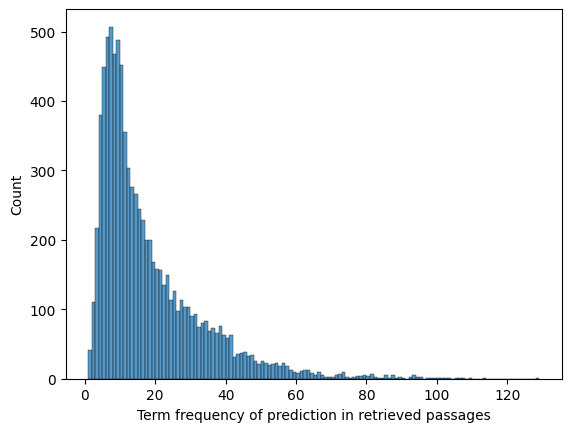

In [202]:
import seaborn as sns
sns.histplot(data=pd_data, x="pred_psg_count", binwidth=1)
plt.xlabel("Term frequency of prediction in retrieved passages") 
plt.show()

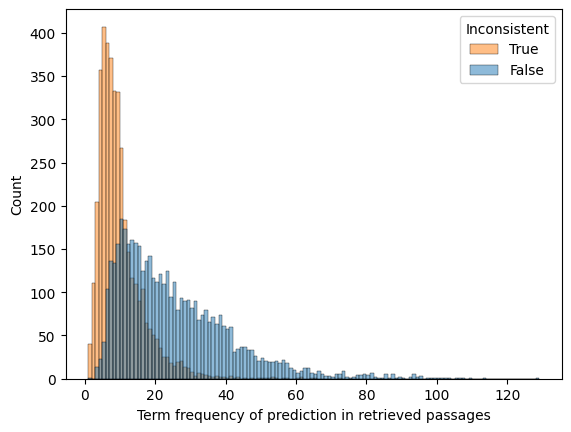

In [203]:
sns.histplot(data=pd_data, x="pred_psg_count", hue="incons_label", binwidth=1)
plt.xlabel("Term frequency of prediction in retrieved passages") 
plt.legend(title="Inconsistent", labels=["True","False"])
plt.show()

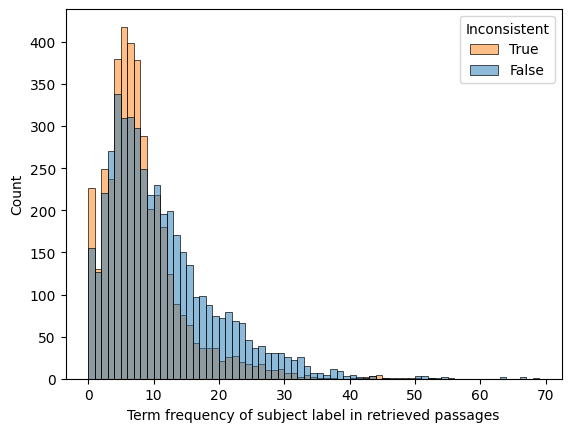

In [204]:
sns.histplot(data=pd_data, x="sub_label_psg_count", hue="incons_label", binwidth=1)
plt.xlabel("Term frequency of subject label in retrieved passages") 
plt.legend(title="Inconsistent", labels=["True","False"])
plt.show()

### Is the model more inconsistent for cases in which term frequency distribution in retrieved passages has high entropy?

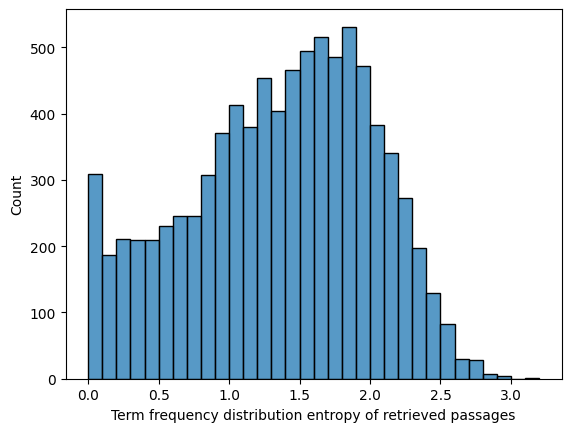

In [226]:
sns.histplot(data=pd_data, x="passage_freq_entropy", binwidth=0.1)
plt.xlabel("Term frequency distribution entropy of retrieved passages") 
plt.show()

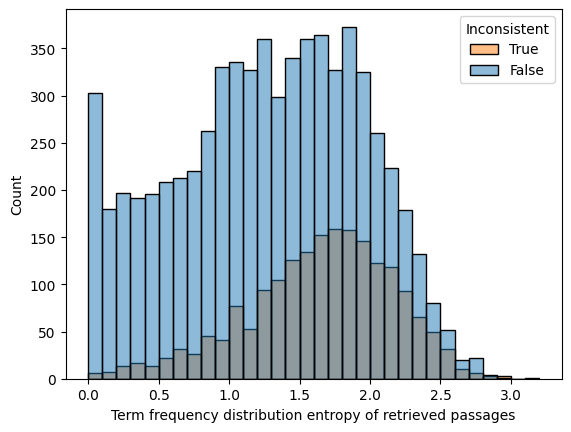

In [227]:
sns.histplot(data=pd_data, x="passage_freq_entropy", hue="incons_label", binwidth=0.1)
plt.legend(title="Inconsistent", labels=["True","False"])
plt.xlabel("Term frequency distribution entropy of retrieved passages") 
plt.show()

### Consider candidate rankings

In [233]:
def get_term_rank(curr_term, candidates, passages):
    term_counts = []
    curr_ix = candidates.index(curr_term)
    for term in candidates:
        term_count = 0
        for passage in passages:
            term_count += passage['title'].count(term) + passage['text'].count(term)
        term_counts.append(term_count)
    return len(candidates)-np.where(np.argsort(term_counts)==curr_ix)[0][0]

pd_data["pred_passage_rank"] = pd_data.apply(lambda row: get_term_rank(row.generation_by_choice, options, row.passages), axis=1)
pd_data

,query,answers,generation,generation_by_choice,choice_confidence,passages,metadata,sub_label,pattern,passage_freq_pred,passage_freq_entropy,incons_label,pred_passage_rank
0,"Rubens Barrichello, who is a citizen of<extra_...",[Brazil],"Brazil Brazil, is Brazilian Brazil a member of...",Brazil,0.986,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who is a citizen of [Y].",Brazil,1.167357,False,1
1,"Rubens Barrichello, who has a citizenship of<e...",[Brazil],"Brazil Brazil, is Brazilian Brazil a driver of...",Brazil,0.923,"[{'id': 'infobox-1921947', 'title': 'Rubens Ba...",{},Rubens Barrichello,"[X], who has a citizenship of [Y].",Brazil,0.920833,False,1
2,"Yves Mirande, a citizen of<extra_id_0>.",[France],"France France, died in 1957 France Yves",France,0.976,"[{'id': '10883439', 'title': 'Yves Mirande', '...",{},Yves Mirande,"[X], a citizen of [Y].",France,1.722958,False,1
3,"Yves Mirande, who holds a citizenship of<extra...",[France],"France France, is French France Yves of France...",France,0.739,"[{'id': '6775490', 'title': 'Thiago Pereira (f...",{},Yves Mirande,"[X], who holds a citizenship of [Y].",France,1.704070,False,1
4,August Gailit is a citizen of<extra_id_0>.,[Estonia],Estonia Estonia and Latvia Estonia he was born...,Estonia,0.902,"[{'id': '21850689', 'title': 'August Gailit', ...",{},August Gailit,[X] is a citizen of [Y].,Estonia,2.300936,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,"Gianni Ferrio, who has a citizenship of<extra_...",[Italy],"Italy Italy, is Italian Italy -born in Italy -...",Italy,0.740,"[{'id': 'infobox-475667', 'title': 'Gianni Fer...",{},Gianni Ferrio,"[X], who has a citizenship of [Y].",Italy,1.387198,False,1
8618,"Sun Beibei, a citizen of<extra_id_0>.",[Singapore],Shandong Shandong Shandong Shandong,Taiwan,0.557,"[{'id': 'infobox-1956267', 'title': 'Sun Beibe...",{},Sun Beibei,"[X], a citizen of [Y].",None,NaN,True,64
8619,"Sun Beibei, who holds a citizenship of<extra_i...",[Singapore],"Singapore Singapore, is also Chinese Singapore...",Singapore,0.650,"[{'id': 'infobox-1860120', 'title': 'Sun Le', ...",{},Sun Beibei,"[X], who holds a citizenship of [Y].",Singapore,0.450561,True,1
8620,Edward Wollstonecraft is a citizen of<extra_id...,[Australia],New South Wales New South Wales.,Australia,0.891,"[{'id': 'infobox-1461400', 'title': 'Edward Wo...",{},Edward Wollstonecraft,[X] is a citizen of [Y].,England,2.022809,False,5


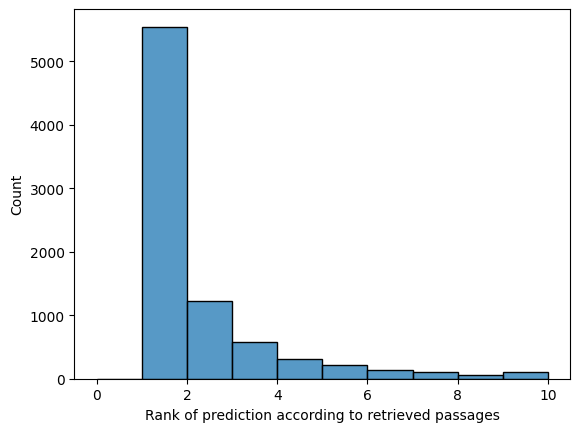

In [245]:
sns.histplot(data=pd_data, x="pred_passage_rank", binwidth=1, binrange=(0,10))
plt.xlabel("Rank of prediction according to retrieved passages") 
plt.show()

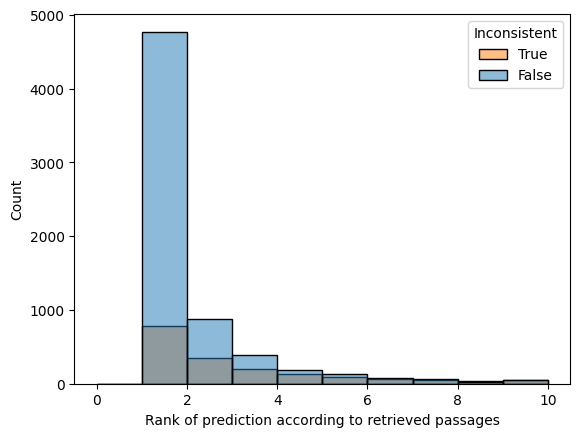

In [247]:
sns.histplot(data=pd_data, x="pred_passage_rank", hue="incons_label", binwidth=1, binrange=(0,10))
plt.legend(title="Inconsistent", labels=["True","False"])
plt.xlabel("Rank of prediction according to retrieved passages") 
plt.show()

### Investigate model confidences

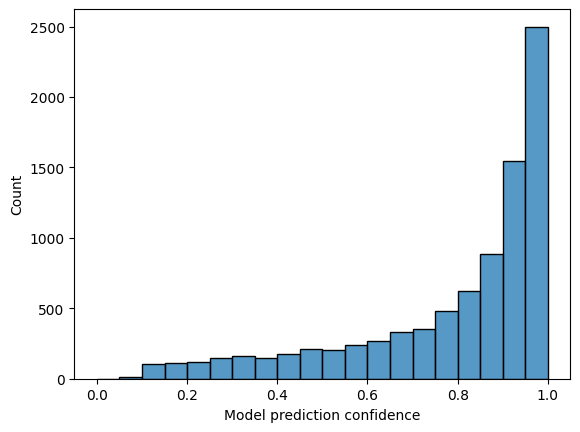

In [273]:
sns.histplot(data=pd_data, x="choice_confidence", binwidth=0.05, binrange=(0,1))
plt.xlabel("Model prediction confidence") 
plt.show()

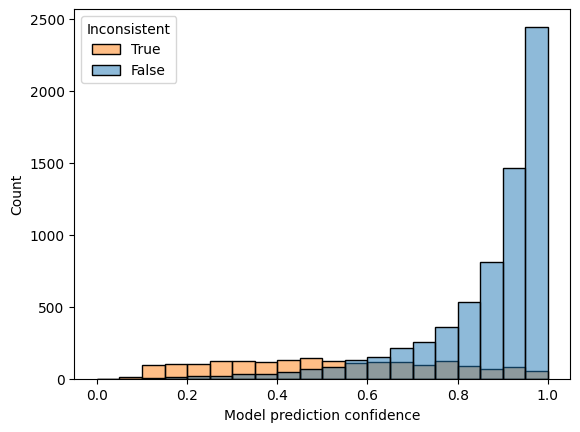

In [274]:
sns.histplot(data=pd_data, x="choice_confidence", hue="incons_label", binwidth=0.05, binrange=(0,1))
plt.legend(title="Inconsistent", labels=["True","False"])
plt.xlabel("Model prediction confidence") 
plt.show()